In [75]:
import pandas as pd
import numpy as np
import json
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

In [76]:
verim06 = "/Users/hakanzip/Desktop/veri-bilimi-10-proje/06_Movie-Recommendation/tmdb_5000_credits.csv"
p6movie = pd.read_csv(verim06)

In [77]:
p6movie.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [78]:
p6movie.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [79]:
p6movie.rename(columns={
    "movie_id": "film_id",
    "title": "film_adi",
    "cast": "oyuncular",
    "crew": "ekip"
}, inplace=True)

In [80]:
p6movie.columns

Index(['film_id', 'film_adi', 'oyuncular', 'ekip'], dtype='object')

In [81]:
p6movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   film_id    4803 non-null   int64 
 1   film_adi   4803 non-null   object
 2   oyuncular  4803 non-null   object
 3   ekip       4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [82]:
p6movie.isnull().sum()

film_id      0
film_adi     0
oyuncular    0
ekip         0
dtype: int64

In [83]:
p6movie["oyuncular"] = p6movie["oyuncular"].apply(ast.literal_eval)
p6movie["ekip"] = p6movie["ekip"].apply(ast.literal_eval)
p6movie["oyuncular"][0][:2], p6movie["ekip"][0][:2]

([{'cast_id': 242,
   'character': 'Jake Sully',
   'credit_id': '5602a8a7c3a3685532001c9a',
   'gender': 2,
   'id': 65731,
   'name': 'Sam Worthington',
   'order': 0},
  {'cast_id': 3,
   'character': 'Neytiri',
   'credit_id': '52fe48009251416c750ac9cb',
   'gender': 1,
   'id': 8691,
   'name': 'Zoe Saldana',
   'order': 1}],
 [{'credit_id': '52fe48009251416c750aca23',
   'department': 'Editing',
   'gender': 0,
   'id': 1721,
   'job': 'Editor',
   'name': 'Stephen E. Rivkin'},
  {'credit_id': '539c47ecc3a36810e3001f87',
   'department': 'Art',
   'gender': 2,
   'id': 496,
   'job': 'Production Design',
   'name': 'Rick Carter'}])

JSON formatındaki sütunları ast.literal_eval() ile listeye çevirdik.

FEATURE ENGINEERING

In [84]:
def get_director(ekip_listesi):
    for kisi in ekip_listesi:
        if kisi.get("job") == "Director":
            return kisi.get("name")
    return np.nan

p6movie["yönetmen"] = p6movie["ekip"].apply(get_director)

Yönetmenleri didikleyip sütun oluşturduk.

In [85]:
def get_top_actors(oyuncu_listesi):
    isimler = [kisi.get("name") for kisi in oyuncu_listesi[:3]] 
    return isimler

p6movie["oyuncular_top3"] = p6movie["oyuncular"].apply(get_top_actors)

Oyuncuları didikleyip sütun oluşturduk.

In [86]:
def combine_features(row):
    oyuncular_string = " ".join(row["oyuncular_top3"])
    if pd.notnull(row["yönetmen"]):
        return f"{row['yönetmen']} {oyuncular_string}"
    else:
        return oyuncular_string
    
p6movie["film_profili"] = p6movie.apply(combine_features, axis=1)

Yönetmen ve oyuncuları tek yerde topladık ayrıca.

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
cv = CountVectorizer()
vektor_matrisi = cv.fit_transform(p6movie["film_profili"])
benzerlik_matrisi = cosine_similarity(vektor_matrisi) #benzerlik skorlarını hesaplıyor

Her filmle diğer filmler arasında benzerlikleri 0-1 arasında hesaplar bu kısım. Şablon çok netti, ileride tekrar değinicem ekisk kaldı bu haliyle.

In [88]:
def film_önermek(film_adi, df, benzerlik_matrisi, öneri_sayisi=10):
    if film_adi not in df["film_adi"].values:
        return f"'{film_adi}' adlı film bulunamadı, tam ismini yazabilir misiniz?"
    
    idx = df[df["film_adi"] == film_adi].index[0]
    skorlar = list(enumerate(benzerlik_matrisi[idx]))
    skorlar = sorted(skorlar, key=lambda x: x[1], reverse=True)
    en_benzerler = skorlar[1:öneri_sayisi+1]
    önerilen_filmler = [df.iloc[i[0]]["film_adi"] for i in en_benzerler]
    
    return önerilen_filmler

Film adına göre öneri veren fonksiyon motoru

In [89]:
film_önermek("The Dark Knight Rises", p6movie, benzerlik_matrisi)

['Batman Begins',
 'The Prestige',
 'The Dark Knight',
 'RoboCop',
 'Public Enemies',
 'Atlantis: The Lost Empire',
 'A Mighty Wind',
 'Terminator Salvation',
 'A Christmas Carol',
 'Dawn of the Planet of the Apes']

In [98]:
film_önermek("Titanic", p6movie, benzerlik_matrisi)

['Revolutionary Road',
 'Insurgent',
 'The Aviator',
 'The Holiday',
 'Divergent',
 'Almost Famous',
 'Romance & Cigarettes',
 'Gangs of New York',
 'Aliens',
 'Avatar']

EDA (EXPLORATORY DATA ANALYSİS)- GÖRSELLEŞTİRME

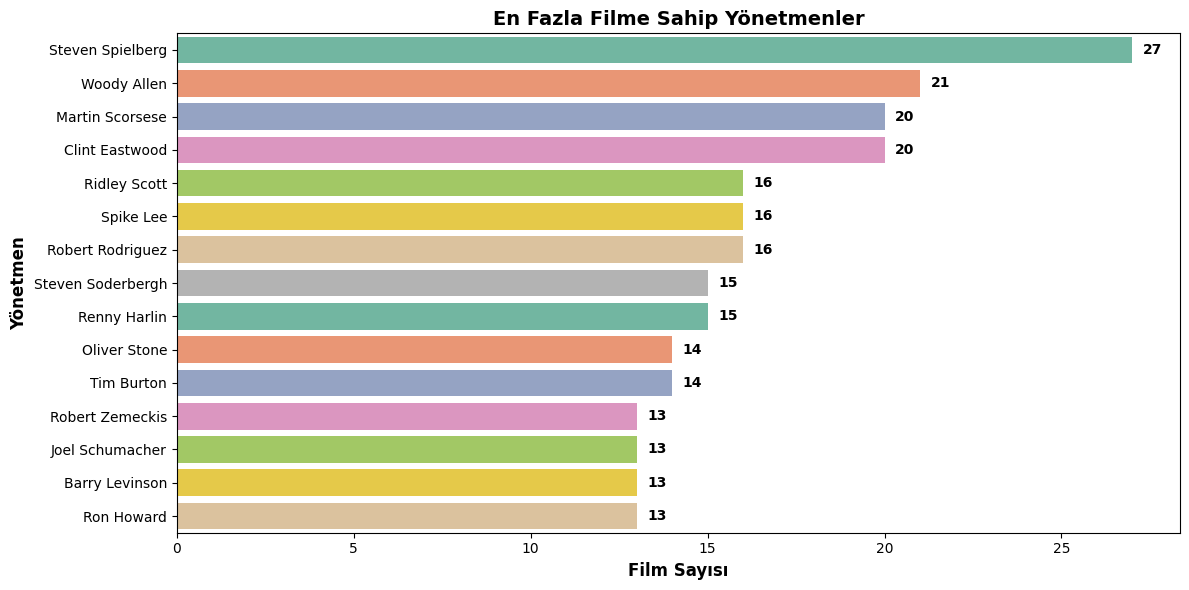

In [90]:
yonetmen_sayilari = p6movie["yönetmen"].value_counts().head(15)
plt.figure(figsize=(12,6))
barplot = sns.barplot(
    x=yonetmen_sayilari.values,
    y=yonetmen_sayilari.index,
    palette="Set2"
)
plt.title("En Fazla Filme Sahip Yönetmenler", fontweight="bold", fontsize=14)
plt.xlabel("Film Sayısı", fontweight="bold", fontsize=12)
plt.ylabel("Yönetmen", fontweight="bold", fontsize=12)

for index, value in enumerate(yonetmen_sayilari.values):
    plt.text(value + 0.3, index, str(value), va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

Bu çubuk grafik veri setinde en fazla filme sahip 15 yönetmeni gösteriyor.

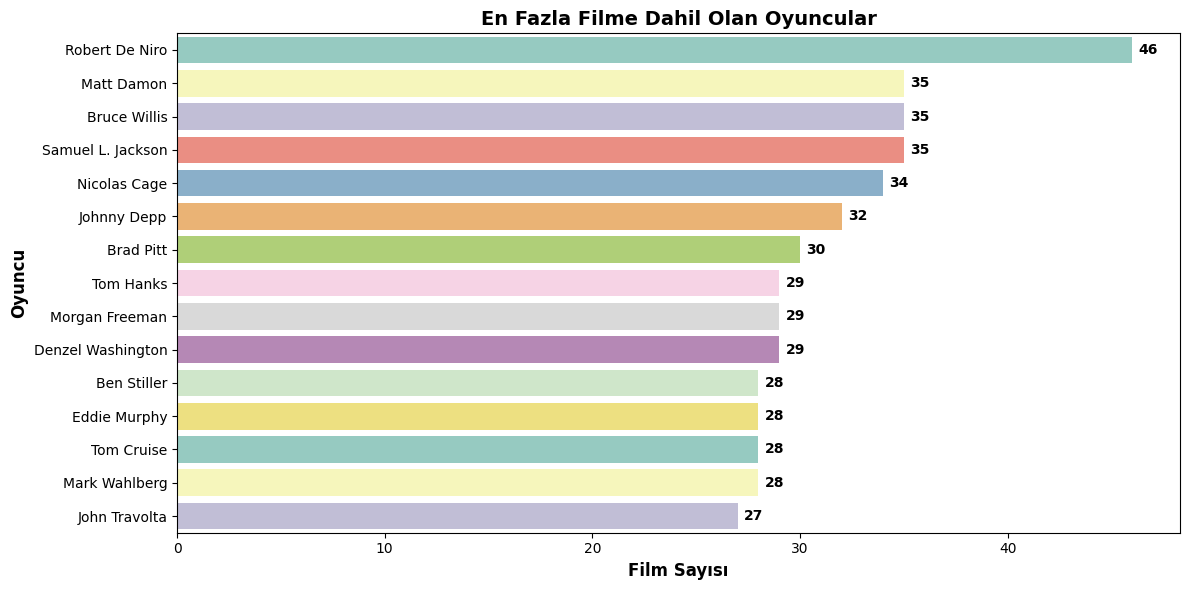

In [91]:
tum_oyuncular = p6movie["oyuncular_top3"].explode()
en_fazla_oyuncular = tum_oyuncular.value_counts().head(15)

plt.figure(figsize=(12,6))
barplot = sns.barplot(
    x=en_fazla_oyuncular.values,
    y=en_fazla_oyuncular.index,
    palette="Set3"
)

plt.title("En Fazla Filme Dahil Olan Oyuncular", fontweight="bold", fontsize=14)
plt.xlabel("Film Sayısı", fontweight="bold", fontsize=12)
plt.ylabel("Oyuncu", fontweight="bold", fontsize=12)

for index, value in enumerate(en_fazla_oyuncular.values):
    plt.text(value + 0.3, index, str(value), va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

Bu çubuk grafik veri setinde en fazla filme sdahil olana 15 yönetmeni gösteriyor.

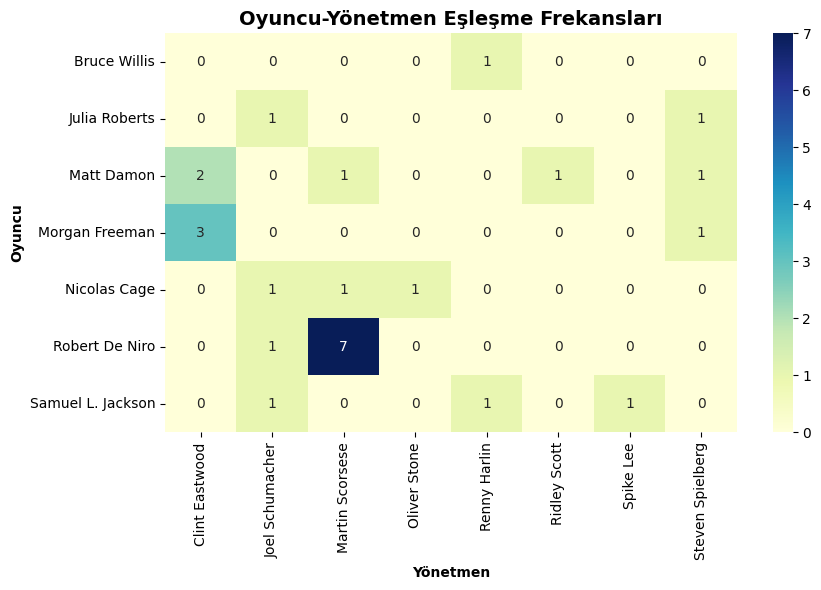

In [92]:
oyuncu_exploded = p6movie.explode("oyuncular_top3")
eslesme_sayilari = oyuncu_exploded.groupby(["oyuncular_top3", "yönetmen"]).size().reset_index(name="frekans")
en_oyuncular = eslesme_sayilari["oyuncular_top3"].value_counts().head(10).index
en_yonetmenler = eslesme_sayilari["yönetmen"].value_counts().head(10).index
filtreli = eslesme_sayilari[
    (eslesme_sayilari["oyuncular_top3"].isin(en_oyuncular)) &
    (eslesme_sayilari["yönetmen"].isin(en_yonetmenler))]
pivot_tablo = filtreli.pivot_table(index="oyuncular_top3", columns="yönetmen", values="frekans", fill_value=0)
pivot_tablo = pivot_tablo.astype(int)
plt.figure(figsize=(9,6))
sns.heatmap(pivot_tablo, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Oyuncu-Yönetmen Eşleşme Frekansları", fontweight="bold", fontsize=14)
plt.xlabel("Yönetmen", fontweight="bold")
plt.ylabel("Oyuncu", fontweight="bold")
plt.tight_layout()
plt.show()

Bu heatmap en sık birlikte çalışan 10 oyuncu ve 10 yönetmenin ortaklık frekanslarını gösteriyor. Scorsese ve De Niro iyi kazanmış.

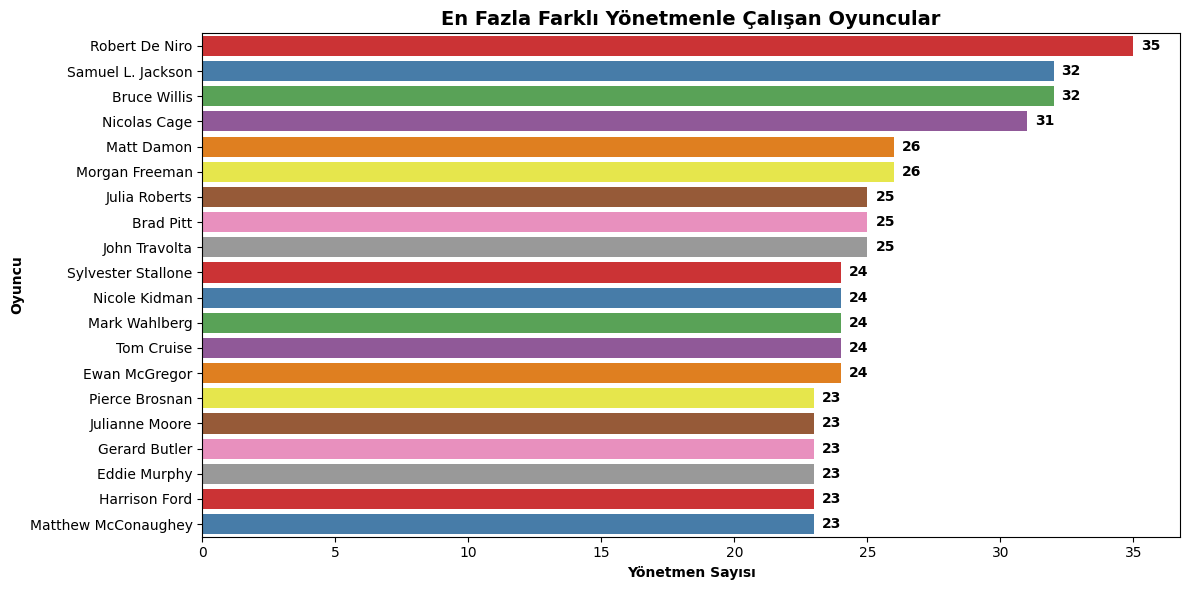

In [93]:
oyuncu_exploded = p6movie.explode("oyuncular_top3")
oyuncu_yonetmen_sayisi = oyuncu_exploded.groupby("oyuncular_top3")["yönetmen"].nunique().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=oyuncu_yonetmen_sayisi.values, y=oyuncu_yonetmen_sayisi.index, palette="Set1")
plt.title("En Fazla Farklı Yönetmenle Çalışan Oyuncular", fontweight="bold", fontsize=14)
plt.xlabel("Yönetmen Sayısı", fontweight="bold")
plt.ylabel("Oyuncu", fontweight="bold")
for index, value in enumerate(oyuncu_yonetmen_sayisi.values):
    plt.text(value + 0.3, index, str(value), va='center', fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

Bu grafikte en fazla farklı yönetmenle çalışılan oyuncuları görüyoruz. 

STREAMLİT

Bu başka bir videonun konusu diyen evrim ağacı gibi daha sonra bakalım buna. Beni aştı bugünlük.

In [94]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 8.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 8.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 9.5 MB/s eta 0:00:00a 0:00:01m

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
